- An introduction to graph data and how it can be represented for use in deep NNs;
- An explanation of graph convolutions, a major building block of common GNNs;
- A tutorial showing how to implement GNNs for molecular property prediction using PyTorch Geometric;
- An overview of methods at the cutting edge of the GNN field.

# Introduction to graph data

Graphs represent a certain way we describe and capture relationships in data. Since graphs are abstract objects, a
concrete representation needs to be defined so the graphs can be operated on. Furthermore, graphs can be defined to have
certain properties that may require different representations:
- Undirected: they consist of nodes that are connected via edges where the order of the nodes and their connection does
not matter.
Mathematically, an undirected graph $G$ is a pair $(V,E)$, where $V$ is a set of the graph's nodes, and $E$ is the set
of edges making up the paired nodes. The graph can then be encoded as a $|V|\times|V|$ adjacency matrix $A$, where each
element $x_{ij}$ is either 1 or 0, denoting an edge between nodes $i$ and $j$. Since the graph is undirected, $A$ has
the property of $x_{ij}=x_{ji}$.
- Directed: there are directed edges. Mathematically they are defined in the same way as an undirected graph, except
that $E$, the set of edges, is a set of ordered pairs. Therefore, $x_{ij}\neq x_{ji}$.
- Labeled: are graphs that have additional information associated with each of their nodes and edges. Given graph $G$,
defined by the node set and edge set $(V,E)$, we define a $|V|\times f_V$ node feature matrix $X$, where $f_V$ is the
length of the label vector of each node. For edge, labels we define an $|E|\times f_E$ edge feature matrix $X_E$, where
$f_E$ is the length of the vector of each edge.

## Representing molecules as graphs

Molecules can be thought of as groups of atoms held together by chemical bonds. There are different atoms corresponding
to different chemical elements, for example, common elements include carobon, oxygen, ecc. Also, there are different
kinds of bonds that form the connection between atoms, for example, single or double bonds.

We can represent a molecule as an unidirected graph with a node label matrix, where each row is a one-hot encoding of
the associated node's atom type. Additionally, there is an edge label matrix where each row is a one-hot encoding of the
associated edge's bond type. Usually, to simplify the representation, hydrogen atoms are sometimes made implicit since
their location can be inferred with basic chemical rules.

# Understanding graph conovlutions

In the context of images, we can think of a convolution as the process of sliding a convolutional filter over an image,
where, at each step, a weighted sum is computed between the filter and the receptive field.

This approach to feature detection is well-suited for images for several reasons, for instance, the following priors we
can place on image data:
1. Shift-invariance: we can still recognize a feature in an image regardless of where it is located.
2. Locality: nearby pixels are closely related;
3. Hierarchy: larger parts of an image can often be broken down into combinations of associated smaller parts.

Another reason convolutions are well-suited for processing images is that the number of trainable parameters does not
depend on the dimensionality of the input.

Like images, graphs also have natural priors that justify a convolutional approach. Both kinds of data, images and
graphs, share the locality prior. However, how we define locality differs. In images, the prior is on locality in 2D
space, while with graphs, it is structural locality. Intuitively, this means that a node that is one edge away is more
likely to be related than a node five edges away.

A stric prior for graph data is permutation invariance, which means that the ordering of the nodes does not affect the
output. Since the same graph can be represented by multiple adjacency matrices, consequently, any graph convolution
needs to be premutation invariant.

A convolutional approach is also desirable for graphs because it can function with a fixed parameter set for graphs of
different sizes (arguably even more important for graphs than images)(Most graph datasets contain graphs of varying
sizes).

While image convolutional operators are standardized, there are many differnet kinds of graph convolutions, and the
development of new graph convolutions is a very active area of research.

## Implementing a basic graph convolution

In [1]:
import numpy as np
import networkx as nx

G = nx.Graph()
blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"
G.add_nodes_from([
    (1,{"color":blue}),
    (2,{"color":orange}),
    (3,{"color":blue}),
    (4,{"color":green}),
])
G.add_edges_from([(1,2),(2,3),(1,3),(3,4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [2]:
def build_graph_color_label_representation(G, mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in nx.get_node_attributes(G,"color").values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size,len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1
    return one_hot_encoding

X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


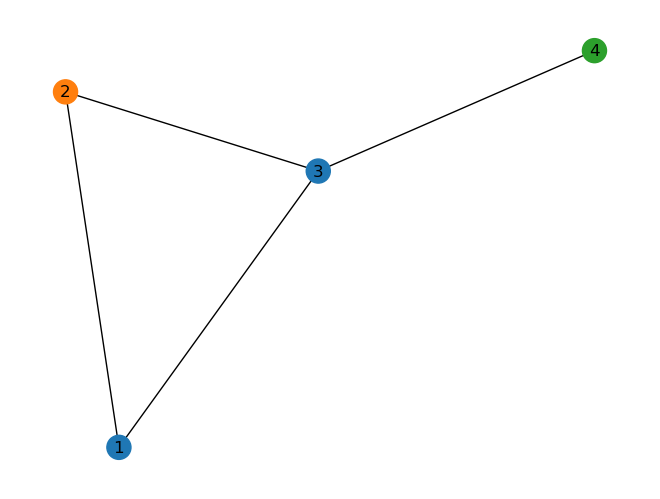

In [3]:
color_map = nx.get_node_attributes(G,"color").values()
nx.draw(G,with_labels=True,node_color=color_map)

With graph convolutions, we can interpret each row of $X$ as being an embedding of the information that is stored at the
node corresponding to that row. Graph convolutions update the embeddings at each node based on the embeddings of their
neighbors and themselves. For our example implementation, the graph convolution will take the following form:
$$x'_i = x_iW_1 + \sum_{j\in N(i)}x_jW_2 + b$$

Here, $x'_i$ is the updated embedding for node $i$; $W_1$ and $W_2$ are $f_{in}\times f_{out}$ matrices of learnable
filter weights; $N(i)$ is the set of neighbors of the node $i$; and $b$ is a learnable bias vector of length $f_{out}$.

The two weight matrices $W_1$ and $W_2$ can be considered filter banks, where each column is an individual filter.

> NOTE: this filter design is most effective when the locality prior on graph data holds. If a value at a node is highly
> correlated with the value at another node many edges away, a single convolution will not capture the relationship.
> Stacking convolutions will caputre more distant relationships.

It may not be clear how to implement the sum over neighbours in matrix form. This is where we utilize the adjacency
matrix $A$. The matrix form of this convolution is $XW_1 + AXW_2$. Here the adjacency matrix acts as a mask to select
nodes and compute the desired sums.

In [ ]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in,f_out)
W_2 = np.random.rand(f_in,f_out)
h = X @ W_1 + A @ X @ W_2
# Computing a forward pass is that easy

Ultimately, we want a graph convolutional layer to update the represetnation of the node information encoded in $X$ by
utilizing the structural information provided by A.

In one of the many frameworks, each node in the graph has an associated hidden state $h_i^{(t)}$, where $i$ is the
node's index at time step $t$. The initial value $h^{(0)}$ is defined as $X_i$, which is the row of $X$ associated with
node $i$. The information about the edges is shown as $e_{ij}$, for the edge between the nodes $i$ and $j$.

Each graph convolution can be split into a massage-passing phase and a node update phase. For undirected graphs, $N(i)$
is the set of nodes that share an edge with node $i$. For directed graphs, $N(i)$ is the set of nodes that have an edge
whose endpoint is node $i$. The message-passing phase can be formulated as follows:
$$m_i = \sum_{j\in N(i)}M_t(h_i^{(t)},h_j^{(t)},e_{ij})$$

Here, $M_t$ is a message function. In our example layer, we define this message function as $M_t = h_j^{(t)}W_2$ (This 
means each neighbor $j$'s features are linearly transformed by a weight matrix, and then summed. Note: The message is
independent of $h_i^{(t)}$ and of the edge features, which is a simplification). The node update phase with the update
function $U_t$ is $h_i^{(t+1)}=U_t(h_i^{(t)},m_i)$. In our example layer, this update is $h_i^{(t+1)} = h_i^{(t)}W_1 +
m_i + b$.

> NOTE: we just rephrased with new notations what was previously shown.

# Implementing a GNN in PyTorch from scratch

In [ ]:
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F

class BasicGraphConvolutionLayer(torch.nn.Module): # Implementation in PyTorch of what was previously discussed
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W2 = Parameter(torch.rand((in_channels,out_channels),dtype=torch.float32))
        self.W1 = Parameter(torch.rand((in_channels,out_channels),dtype=torch.float32))
        self.bias = Parameter(torch.zeros((out_channels),dtype=torch.float32))

    def forward(self, X, A):
        potential_msgs = X @ self.W2
        propagated_msgs = A @ potential_msgs
        root_update = X @ self.W1
        output = propagated_msgs + root_update + self.bias
        return output
    
def global_sum_pool(X, batch_mat): # Aggregates all of a graph's node embeddings into a fixed-sized output
    # Similar to global average pooling in CNNs
    # Watch the image on page 653 to better understand the workings of batch_mat
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return batch_mat @ X

class NodeNetwork(torch.nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.conv_1 = BasicGraphConvolutionLayer(input_features,32)
        self.conv_2 = BasicGraphConvolutionLayer(32,32)
        self.fc_1 = torch.nn.Linear(32,16)
        self.out_layer = torch.nn.Linear(16,2)

    def forward(self, X, A, batch_mat):
        x = F.relu(self.conv_1(X,A))
        x = F.relu(self.conv_2(x,A)) # Perform two graph convolutions
        output = global_sum_pool(x,batch_mat) # Poll the node embedding
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1) # Output class membership probability


Talking about the pooling, summing the node embeddings results in a loss of information, so reshaping the data would be
preferable, but since graphs can have different sizes, this is not feasible.

When all data in a dataset has the same dimensionality, batching the data is as strainghtforward as adding a dimension
by stacking the data. Since graph sizes vary, this approach is not feasable with graph data unless padding is used. But
padding is very inefficient in cases where graph sizes can vary substantially so, in practice, a better way to deal with
this problem is to treat each batch as a single graph where each graph in the batch is a subgraph that is disconnected
from the rest.

Suppose we are given graphs $G_1,...,G_k$ of sizes $n_1,...,n_k$ with $f$ features per node. In addition, we are given
the corresponding adjacency matrices $A_1,...,A_k$ and feature matrices $X_1,...,X_k$. Let $N$ be the total number of
nodes, $N= \sum^k_{i=1} n_i,s_1 = 0$ and $s_i=s_{i-1}+n_{i-1}$ for $1<i\leq k$. We define a graph $G_B$ with $N\times N$
adjacency matrix $A_B$ and $N\times f$ feature matrix $X_B$.

Using Python index notation, $A_B[s_i:s_i+n_i,s_i:s_i+n_i] = A_i$, and all other elements of $A_B$ outside these index sets
are 0. Additionally, $X_B[s_i:s_i+n_i,:] = X_i$.

By design, disconnected nodes will never be in the same receptive field of a graph convolution. As a result, when
backpropagating gradients of $G_B$ through graph convolutions, the gradients attached to each graph in the batch will
be independent. This means that if we treat a set of graph convolutions as a function $f$, if $h_B=f(X_B,A_B)$ and 
$h_i = f(X_i, A_i)$, then $h_B[s_i:s_i+n_i,:] = h_i$.

If the sum global pooling extracts the sums of each $h_i$ from $h_B$ as separate vectors, passing that stack of vectors
through fully connected layers would keep the gradients of each item in the batch separate throughout the entire
backpropagation.

`batch_mat` in fact serve as a graph selection mask, that keeps the graphs in the batch separate (avoiding graphs to
influence each other's gradients).

In [13]:
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx] + graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size,tot_len]).float()
    for idx, (start,stop) in enumerate(zip(starts,stops)):
        batch_mat[idx,start:stop] = 1
    return batch_mat

def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)

    batch_mat = get_batch_tensor(sizes)

    feat_mats = torch.cat([graph['X'] for graph in batch],dim=0)

    labels = torch.cat([graph['y'] for graph in batch],dim=0)

    batch_adj = torch.zeros([tot_size,tot_size],dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size,accum:accum+g_size] = adj
        accum = accum + g_size
    repr_and_label = {'A': batch_adj, 'X': feat_mats, 'y':labels, 'batch': batch_mat}
    return repr_and_label

In [14]:
def get_graph_dict(G,mapping_dict):
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float() # The .todense() is used because the
    # .adjacency_matrix() method produces a sparse representation
    X = torch.from_numpy(build_graph_color_label_representation(G,mapping_dict)).float()
    y = torch.tensor([[1,0]]).float() # Labels here are just set arbitrarily since we won't use this for training
    # it's just a proof of concept
    return {'A':A,'X':X,'y':y,'batch':None}

In [15]:
# Building 4 graphs to treat as a dataset
blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"
mapping_dict = {green: 0, blue: 1, orange: 2}
G1 = nx.Graph()
G1.add_nodes_from([
    (1,{"color": blue}),
    (2,{"color": orange}),
    (3,{"color": blue}),
    (4,{"color": green}),
])
G1.add_edges_from([(1,2),(2,3),(1,3),(3,4)])
G2 = nx.Graph()
G2.add_nodes_from([
    (1,{"color": orange}),
    (2,{"color": orange}),
    (3,{"color": green}),
    (4,{"color": green}),
    (5,{"color": blue}),
    (6,{"color": orange}),
])
G2.add_edges_from([(5,1),(2,3),(3,1),(3,4),(2,5),(6,1)])
G3 = nx.Graph()
G3.add_nodes_from([
    (1,{"color": green}),
    (2,{"color": green}),
    (3,{"color": orange}),
    (4,{"color": orange}),
    (5,{"color": blue}),
])
G3.add_edges_from([(5,1),(2,3),(3,1),(3,4)])
G4 = nx.Graph()
G4.add_nodes_from([
    (1,{"color": blue}),
    (2,{"color": blue}),
    (3,{"color": green}),
])
G4.add_edges_from([(2,3),(1,2)])
graph_list = [get_graph_dict(graph, mapping_dict) for graph in [G1, G2, G3, G4]]

In [16]:
from torch.utils.data import Dataset
class ExampleDataset(Dataset):
    def __init__(self,graph_list):
        super().__init__()
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, index):
        mol_rep = self.graphs[index]
        return mol_rep

In [17]:
from torch.utils.data import DataLoader
dset = ExampleDataset(graph_list)

# Note that we don't need to use something special, we just need to specify to the DataLoader how to collate graphs
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

In [20]:
node_features = 3
net = NodeNetwork(node_features)

# That's how you use the model for a batch
batch_results = []
for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

# That's what changes for a single graph
G1_rep = dset[1]
G1_single = net(G1_rep['X'],G1_rep['A'],G1_rep['batch']).detach()
# Absolutely nothing (since batch defines what to consider for each graph)

G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single,G1_batch))

tensor(True)

# Implementing a GNN using the PyTorch Geometric library

The PyTorch Geometric Library simplifies the process of training GNNs. We apply the GNN to QM9, a dataset consisting of
small molecules, to predict isotropic polarizability, which is a measure of a molecule's tendency to have its charge
distorted by an electric field.

In [21]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn as nn

dset = QM9('.')
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

In [22]:
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

The data object is a convenient, flexible wrapper for graph data.

The labels in the QM9 are a bunch of physical properties of the molecules, such as dipole moment, free energy, enthalpy
or isotopic polarization.

In this dataset we'll want to use a graph convolution that can utilize edge features. That's why we are using
`torch_geometric.nn.NNConv`.

The convolution in the NNConv layer takes the following form:
$$X_i^{(t)} = WX_i^{(t-1)} + \sum_{j\in N(i)} X_j^{(t-1)}h_\Theta(e_{i,j})$$

Here, $h$ is a neural network parameterized by a set of weights $\Theta$ ($h$ will produce a weigth matrix), and $W$ is
a weight matrix for the node labels (it's similar to the graph convolution that we implemented previously, with the only
difference being that the $W_2$ equivalent here is the neural network $h$, parametrized based on the edge labels).

In [28]:
class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features,32),
            nn.ReLU(),
            nn.Linear(32,num_node_features*32),
        )
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features,32),
            nn.ReLU(),
            nn.Linear(32,16*32),
        )
        # Understand that the purpose of conv_net 1 and 2 is to generate a weight matrix that will be used instead of
        # W_2 (in the previous from-scratch version). That's why the last linear layer uses the product of the
        # input_features and the output_features numbers of the NNConv, as its output_features number. Doing that it
        # will output a vector of size input_features*output_features, that will be reshaped into a matrix of dimensions
        # input_features X output_features. That matrix will do a matrix multiply with the node embeddings of the
        # neighbors of the node of interest, in order to correctly permute the data.

        self.conv1 = NNConv(num_node_features,32,conv1_net)
        self.conv2 = NNConv(32,16,conv2_net)

        self.fc_1 = nn.Linear(16,32)
        self.out = nn.Linear(32,1)
    
    def forward(self,data):
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        x = F.relu(self.conv1(x,edge_index,edge_attr))
        x = F.relu(self.conv2(x,edge_index,edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [29]:
from torch.utils.data import random_split
train_set, valid_set, test_set = random_split(dset,[110000,10831,10000])
train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_set,batch_size=32,shuffle=False)
test_loader = DataLoader(test_set,batch_size=32,shuffle=False)

In [30]:
qm9_node_feats, qm9_edge_feats = 11, 4
net = ExampleNet(qm9_node_feats,qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(),lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label
device = "mps"
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [31]:
for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:,target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    
    for batch in valid_loader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:,target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.34 | validation avg. loss: 0.25
Epochs: 1 | epoch avg. loss: 0.13 | validation avg. loss: 0.13
Epochs: 2 | epoch avg. loss: 0.10 | validation avg. loss: 0.09
Epochs: 3 | epoch avg. loss: 0.09 | validation avg. loss: 0.10


In [32]:
net.eval()
predictions = []
real = []
for batch in test_loader:
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:,target_idx].detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

Text(0, 0.5, 'Predicted isotropic polarizability')

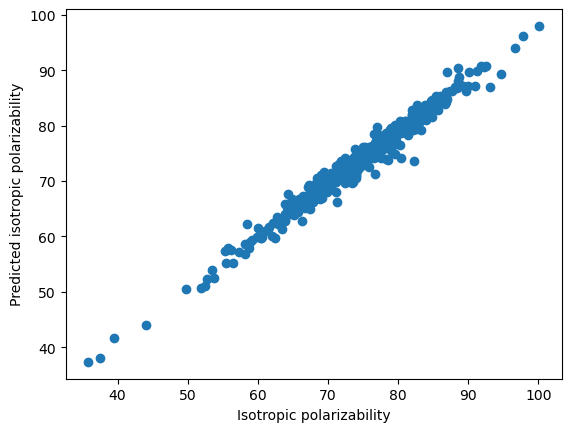

In [33]:
import matplotlib.pyplot as plt
plt.scatter(real[:500],predictions[:500])
plt.xlabel('Isotropic polarizability')
plt.ylabel('Predicted isotropic polarizability')

# Other GNN layers and recent developments

## Spectral graph convolutions

The graph convolutions utilizized up until now have all been spatial in nature. This means that they aggregate
information based on the topological space associated with the graph, which is just a fancy way of saying that spatial
convolutions operate on local neighborhoods of nodes. So, in order to capture global patterns, GNNs need to stack
multiple convolutions in order to operate correctly. In situations where these global patterns are important, but
network depth needs to be limited, spectral graph convolutions are an alternative kind of convolution to consider.

They operate differently than spatial convolutions, by utilizing the graph's spectrum (its set of eigenvalues), by
computing the eigendecomposition of a normalized version of the graph's adjacency matrix called the *graph Laplacian*.

For an undirected graph, the Laplacian matrix of a graph is defined as $L = D - A$, where $A$ is the adjacency matrix of
the graph and $D$ is the degree matrix (diagonal matrix where the element on the diagonal in the row with index $i$ is
the number of edges in and out of the node associated with the $i$ th row of the adjacency matrix).

The Laplacian itself isn't usefull, but it's a framework from which we can understand how much each node its "distant"
from its neighbours (in terms of similarity (obviously there should be a signal function involved, to process each 
node)).

$L$ is a real-valued symmetric matrix, and it has been proven that real-valued symmetric matrices can be decomposed as
$L = Q \Lambda Q^T$, where $Q$ is an othogonal matrix whose columns are the eigenvectors of $L$, and $\Lambda$ is a
diagonal matrix whose elements are the eigenvalues of $L$. You can think of $Q$ as providing the underlying
representation of the graph's structure.

For this reason, spectral convolutions utilize the alternative representation of the structurefrom $Q$ to update the 
node embeddings.

The following example of a spectral convolution utilizes the eigendecomposition of the symmetric normalized graph
Laplacian, which is defined for a graph as follows:
$$L_{sym} = I - D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$$
where $I$ is the identity matrix. This is used because the normalization of the graph Laplacian can help stabilize the
gradient-based training procedure similar to feature standardization.

Deepening a bit we have:
$$\bigl(D^{-\frac{1}{2}}AD^{-\frac{1}{2}}\bigr)_{ij} = \frac{A_{ij}}{\sqrt{d_id_j}}$$
That's a normalization of the adjacency matrix (So it's no longer just "1" if two nodes are connected, but rather scaled
by their degrees).
Now that the values are scaled, we use 1 instead of the real number or connected edges.

Given that $Q\Lambda Q^T$ is the eigendecomposition of $L_{sym}$, the graph convolution is defined as follows:
$$X' = Q(Q^TX\odot Q^TW)$$

Imagine that $Q^TX$ is a matrix where each column represent each feature of the graph expressed in the graph "frequency"
domain (the eigenvector space), so it tells you how strongly that feature aligns with each of the graph's frequency
modes (each eigenvector).

The rows instead, tell you about the specific graph frequency (eigenvector), applied across all features (the projection
of each feature onto the $i$ th eigenvector).

This works that way because each column of $Q$ represent a pattern over all nodes (like a frequency in the fourier
transform), having a row per node.

So $Q^TX$ maps the features onto the spectral space, and $Q^TW$ does the same thing to a learnable matrix. The two will
be multiplied element-wise together so that the second filters the first, and only then $Q^T = Q^{-1}$ maps the
resulting matrix back to the graph space.

The problems with this approach are that:
- As this method is structured, $W$ is dependent on the size of the graph;
- The spectral convolution can only be applied to graphs of the same size;
- The receptive field of this convolution is the whole graph, and this cannot be tuned in the current formulation;
- Computing a graph's eigendecomposition has a computation complexity of $O(N^3)$.

## Pooling

While the downsampling provided by pooling layers has been beneficial in CNN architectures, the benefit of downsampling 
in GNNs has not been realized as clearly.

Pooling layers for image data (ab)use spatial locality, which graphs do not have. If a clustering of the nodes in a
graph is provided, we can define how a graph pooling layer shoul pool nodes. However, it is unclear how to define
optimal clustering, and different clustering approaches may be favored for different contexts. Even after clustering is
determined, if nodes are downsampled, it is unclear how the remaining nodes should be connected.

As with CNNs, there are mean and max pooling layers that can be applied to GNNs. Note that given a clustering of nodes,
each cluster becomes a node in a new graph.

In this case, eac cluster's embedding is equal to the mean or max of the embeddings of the nodes in the cluster.

To address connectivity, the cluster is assigned the union of all edge indices in the cluster. For example, if nodes
$i, j, k$ are assigned to cluster $c_1$, any node, or cluster containing a node, that shared an edge with $i, j$ or $k$
will share an edge with $c_1$.

A more complex pooling layer, *DiffPool*, tries to address both clustering and downsampling simultaneously. This layer
learns a soft cluster assignment matrix $S\in \mathbb{R}^{n\times c}$, which distributes $n$ node embeddings into $c$
clusters. With this, $X$ is updated as $X' = S^TX$ and $A$ as $A' = S^TA^TS$. Notably, $A'$ no longer contains discrete
values and can instead be viewed as a matrix of edge weightings. Over time, DiffPool converges to an almost hard
clustering assignment with interpretable structure.

Another pooling method, top-$k$ pooling, drops nodes from the graph instead of aggregating them, which circumvents
clustering and connectivity issues. This obviously comes with a loss of the information contained by the dropped nodes,
but as long as convolutions happen before pooling, the network can learn to avoid this. The dropped nodes are selected
using a projection score against a learnable vector $p$. The actual formulation to compute $(X',A')$, is:
$$y=\frac{X_p}{||p||}, i=top-k(y,k), X' = (X\odot tanh(y))_i, A' = A_{ii}$$

Here, top-k selects the indexes of $y$, with the top $k$ values and the index vector $i$ being used to drop rows of $X$
and $A$. 

## Normalization

As a quick review of normalization, we mean that given a set of feature values $x_1,...,x_n$, we update the values with
$\frac{x_i-\mu}{\sigma}$, where $\mu$ is the mean and $\sigma$ the standard deviation of the set of values.

The GraphNorm team showed that the mean statistic after aggregation in a graph convolution can contain meaningful
information, so discarding it completely may not be desirable, so they introduced GraphNorm.

Let $h$ be the matrix of node embeddings. Let $h_{i,j}$ be the $j$-th feature value of node $v_i$, where $i=1,...,n$,
and $j=1,...,d$. GraphNorm takes the following form:
$$\gamma_j\frac{h_{ij}-\alpha_j\cdot\mu_j}{\hat{\sigma}_j} + \beta_j$$

Here, $\mu_j = \frac{\sum_{i=1}^nh_{ij}}{n}$ and $\hat{\sigma}_j = \frac{\sum_{i=1}^n(h_{ij}-\alpha_j\mu_j)^2}{n}$. Here
$\alpha,\beta,\gamma$ are all learnable parameters.

Another graph normalization technique is MsgNorm. MsgNorm corresponds to the message-passing formulation of graph
convolutions mentioned earlier in the chapter. Using message-passing network nomenclature, after a graph convolution has
summed over $M_t$ and produced $m_i$ but before updating the nodes embedding with $U_t$, MsgNorm normalizes $m_i$ with
the following formula:
$$m'_i = s\cdot||h_i||_2\cdot\frac{m_i}{||m_i||_2}$$

where, $s$ is a learnable scaling factor and the intuition behind this approach is to normalize the features of the
aggregated messages in a graph convolution (there is no theory in support this normalization approach, it has worked
well in practice).

## Conclusion

Testing a variety of normalization methods during model development and optimization is a reasonable and recommended
approach.